In [1]:
import pandas as pd
from pathlib import Path
import os
import numpy as np
from numpy import concatenate

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import Callback
from keras.layers import Activation

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
%matplotlib inline

In [2]:
"""
    Create place for model save
    
    Arguments:
    ----------
    models: str
            Name of directory model will be saved in
"""
if not os.path.isdir(os.path.realpath('models')):
    os.mkdir(os.path.realpath('models'))

In [3]:
df_healthy = pd.read_csv('result_healthy_pandas.csv', engine='python', header=None)
df_healthy.head()

,0,1,2,3
0,0,100,0.014603,0.192922
1,1,100,0.054449,0.164364
2,2,100,0.107646,0.090811
3,3,100,0.133722,0.086496
4,4,100,0.112652,0.099235


#df_healthy.loc[df_healthy[1] == 100]

In [4]:
df_faulty = pd.read_csv("result_faulty_pandas.csv", engine='python', header=None)
df_faulty.head()

,0,1,2,3
0,0,105,-0.083004,-0.402075
1,1,105,-0.195734,-0.004725
2,2,105,0.233419,-0.106631
3,3,105,0.103958,-0.074169
4,4,105,-0.181115,0.208947


In [5]:
"""
    Get actual recording data; drop file_id and index data
    
    Arguments:
    ----------
    df: DataFrame
            DataFrame storing either "result_healthy_pandas.csv" or "result_faulty_pandas.csv"
    file_id: str/int
            Identifier of .mat file data comes from
"""

def get_recording(df,file_id):
    return np.array(df.sort_values(by=0, ascending=True).loc[df[1] == file_id].drop(0,1).drop(1,1))


In [6]:
healthy_sample = get_recording(df_healthy,100)
faulty_sample = get_recording(df_faulty,125)

Text(0.5, 1.0, 'Healthy samples - Total view')

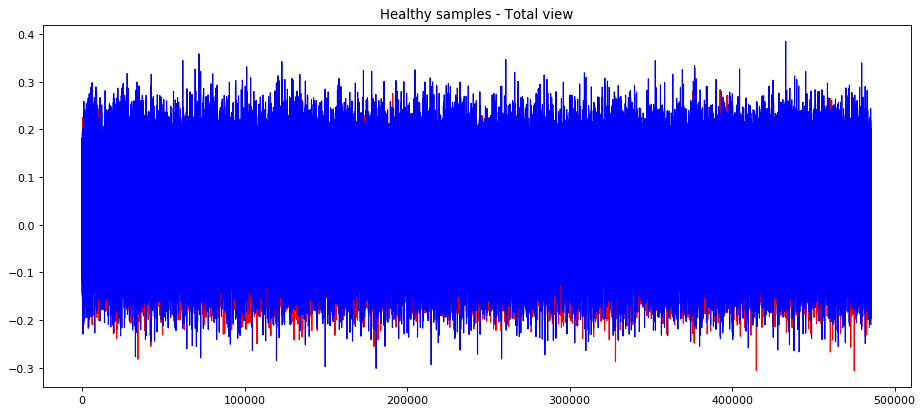

In [7]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(healthy_sample)
ax.plot(range(0,size), healthy_sample[:,0], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), healthy_sample[:,1], '-', color='blue', animated = True, linewidth=1)
ax.set_title("Healthy samples - Total view")

Text(0.5, 1.0, 'Faulty samples -Total view')

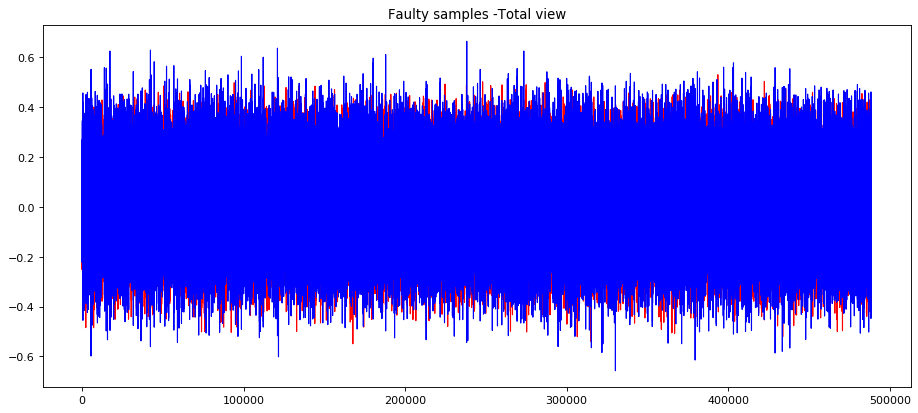

In [8]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(faulty_sample)
ax.plot(range(0,size), faulty_sample[:,1], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), faulty_sample[:,0], '-', color='blue', animated = True, linewidth=1)
ax.set_title("Faulty samples -Total view")

Text(0.5, 1.0, 'Healthy samples - Closer look')

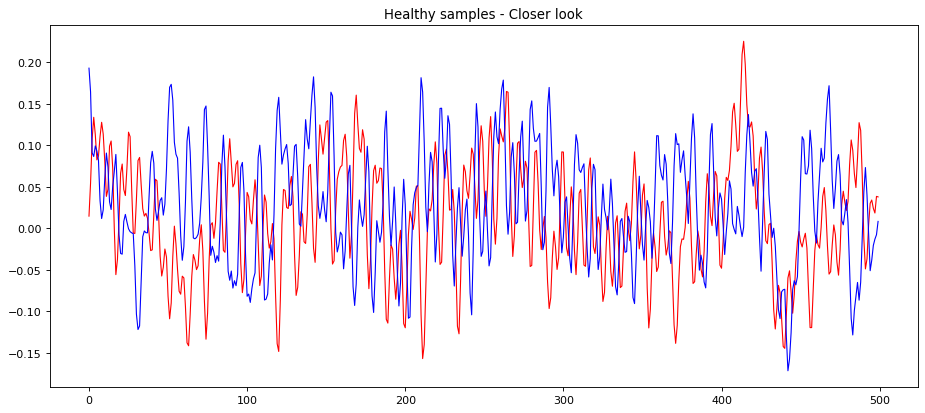

In [9]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
ax.plot(range(0,500), healthy_sample[:500,0], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,500), healthy_sample[:500,1], '-', color='blue', animated = True, linewidth=1)
ax.set_title("Healthy samples - Closer look")

Text(0.5, 1.0, 'Faulty samples - Closer look')

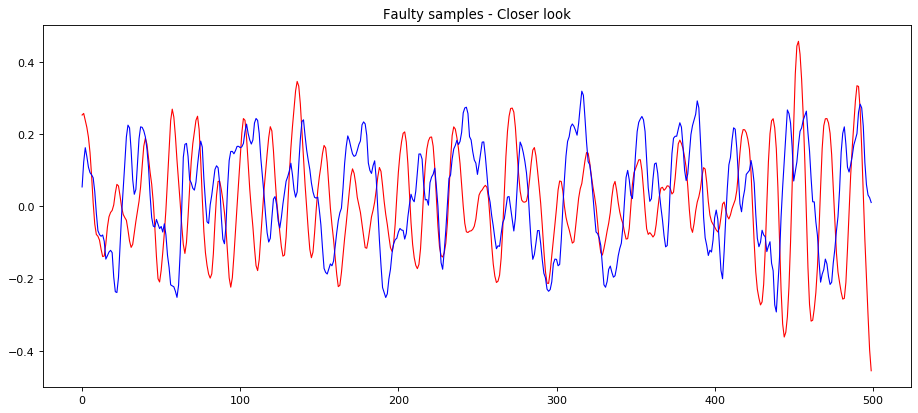

In [10]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
ax.plot(range(0,500), faulty_sample[:500,0], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,500), faulty_sample[:500,1], '-', color='blue', animated = True, linewidth=1)
ax.set_title("Faulty samples - Closer look")

In [11]:
"""
    Callback function (reqd) for loss history and model checkpoints
    
    Arguments:
    ----------
    Callback: tf.keras.callbacks.Callback()
    self/logs
"""
class LossHist(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [17]:
"""
    ML/NN Network design
    
    Design:
    -------
    Epochs/Timesteps = 100 samples
    Dimensions = 2 recordings
    
    Architecture:
    -------------
    - Sequential
    - LSTM (size => 100/2 = 50)
    - Dense (size = 2)

"""

timesteps = 100
dim = 2
lossHistory = LossHist()

model = Sequential()
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(Dense(2))
model.compile(loss='mae', optimizer='adam')

def train(data):
    history = model.fit(data, data, epochs=20, batch_size=72, validation_data=(data, data), verbose=1, shuffle=False,callbacks=[lossHistory])
    model.save('models/k_model.h5',
    overwrite=True,
    include_optimizer=True,
    save_traces=True,
              )
def score(data):
    yhat =  model.predict(data)
    return yhat

In [18]:
"""
    Enabling TensorFlow backend in compatibility mode
"""

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [19]:
"""
    Trim samples to form proper epochs in scope of timesteps
    
    Arguments:
    ----------
    df: DataFrame
        Intending df for trimming
    file_id: str/int
        Name of .mat file iterating in epoch
"""

def create_trimmed_recording(df,file_id):
    recording = get_recording(df,file_id) 
    samples = len(recording)
    trim = samples % 100
    recording_trimmed = recording[:samples-trim]
    recording_trimmed.shape = (int((samples-trim)/timesteps),timesteps,dim)
    return recording_trimmed


#df_healthy.drop(0,1).drop(2,1).drop(3,1)

In [20]:
pd.unique(df_healthy.iloc[:,1])

array([100,  97,  98], dtype=int64)

In [21]:
"""
    Training on Healthy data and comparing accuracy

"""


file_ids = pd.unique(df_healthy.iloc[:,1])
start = time.time()
for file_id in file_ids:
    recording_trimmed = create_trimmed_recording(df_healthy,file_id)
    print("Starting training on %s" % (file_id))
    train(recording_trimmed)
    print("Finished training on %s after %s seconds" % (file_id,time.time()-start))

print("Finished job on after %s seconds" % (time.time()-start))
healthy_losses = lossHistory.losses


Starting training on 100
Epoch 1/20
68/68 [==============================] - 5s 53ms/step - loss: 0.0487 - val_loss: 0.0322
Epoch 2/20
68/68 [==============================] - 3s 48ms/step - loss: 0.0270 - val_loss: 0.0137
Epoch 3/20
68/68 [==============================] - 3s 47ms/step - loss: 0.0104 - val_loss: 0.0043
Epoch 4/20
68/68 [==============================] - 3s 47ms/step - loss: 0.0041 - val_loss: 0.0034
Epoch 5/20
68/68 [==============================] - 3s 47ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 6/20
68/68 [==============================] - 3s 47ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 7/20
68/68 [==============================] - 3s 47ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 8/20
68/68 [==============================] - 3s 47ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 9/20
68/68 [==============================] - 3s 49ms/step - loss: 0.0016 - val_loss: 0.0036
Epoch 10/20
68/68 [==============================] - 3s 47ms/step - loss: 0.0027 - v

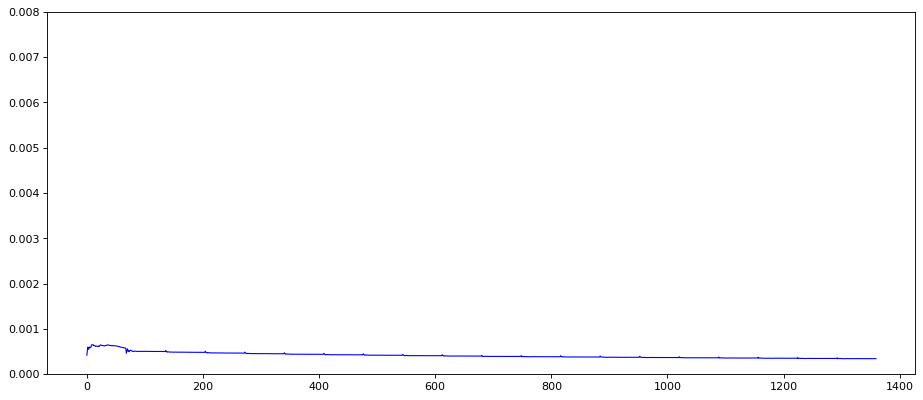

In [22]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(healthy_losses)
plt.ylim(0,0.008)
ax.plot(range(0,size), healthy_losses, '-', color='blue', animated = True, linewidth=1)

"""
    Short example of model; for a single file_id
"""

start = time.time()
for file_id in [105]:
    recording_trimmed = create_trimmed_recording(df_faulty,file_id)
    print("Starting training on %s" % (file_id))
    train(recording_trimmed)
    print("Finished training on %s after %s seconds" % (file_id,time.time()-start))

print("Finished job on after %s seconds" % (time.time()-start))
faulty_losses = lossHistory.losses

In [23]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11973271940207618965
]


In [24]:
"""
    Predicting on Faulty data and comparing accuracy - Autoencoder behaviour

"""

file_ids = pd.unique(df_faulty.iloc[:,1])
start = time.time()
for file_id in file_ids:
    recording_trimmed = create_trimmed_recording(df_faulty,file_id)
    print("Starting training on %s" % (file_id))
    train(recording_trimmed)
    print("Finished training on %s after %s seconds" % (file_id,time.time()-start))

print("Finished job on after %s seconds" % (time.time()-start))
faulty_losses = lossHistory.losses


Starting training on 105
Epoch 1/20
17/17 [==============================] - 1s 54ms/step - loss: 0.0054 - val_loss: 0.0042
Epoch 2/20
17/17 [==============================] - 1s 53ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 3/20
17/17 [==============================] - 1s 53ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 4/20
17/17 [==============================] - 1s 54ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 5/20
17/17 [==============================] - 1s 54ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 6/20
17/17 [==============================] - 1s 56ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 7/20
17/17 [==============================] - 1s 54ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 8/20
17/17 [==============================] - 1s 55ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 9/20
17/17 [==============================] - 1s 55ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 10/20
17/17 [==============================] - 1s 55ms/step - loss: 0.0017 - v

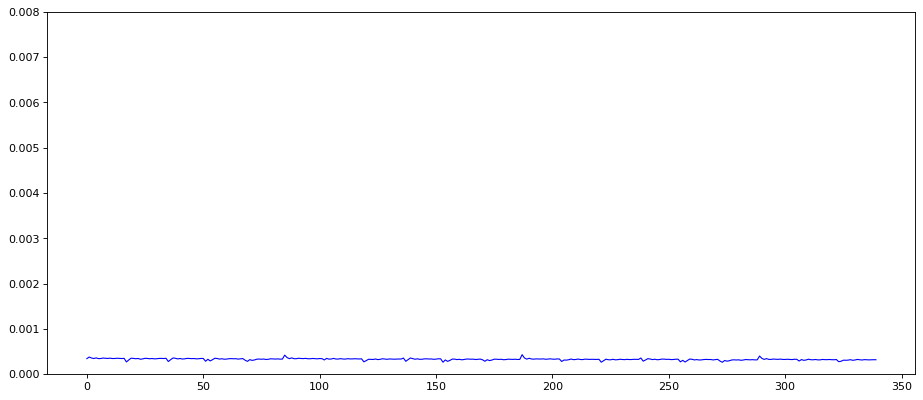

In [25]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(faulty_losses)
plt.ylim(0,0.008)
ax.plot(range(0,size), faulty_losses, '-', color='blue', animated = True, linewidth=1)